<a href="https://colab.research.google.com/github/kay-squared/PyTorchLearn/blob/main/03_PyTorch_NN_ComputerVision_Video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 03. Computer Vision with PyTorch

Resources:

https://www.learnpytorch.io/03_pytorch_computer_vision/

https://github.com/mrdbourke/pytorch-deep-learning/blob/main/03_pytorch_computer_vision.ipynb

Questions in https://github.com/mrdbourke/pytorch-deep-learning/discussions

Computer vision can be used for 
* binary classification
* multiclass classification (e.g. nutrify)
* object detection
* segmentation (apple fotos: https://machinelearning.apple.com/research/panoptic-segmentation or tesla computer vision, e.g. https://www.youtube.com/watch?v=Vz6yw7iGzZM)
* ...

What we will cov er
* get a dataset (torchvision.datasets)
* architecture of a CNN
* end-to-end multiclass image classification



## Input Data

Typical: 24-bit rgb images (3 times 8-bit)

```
[[red1,red2,...,redn],[g1,g2,...,],[b1, b2, ...,bn]]
```
**One Image** is often represented by the input tensor of shape **NHWC**

```
Shape_input = [batch_size, width, height, color_channels]
```
However, the pytorch library currently expects a different representation: **NCHW** which puts the color channels before width and height !!
```
Shape_input = [batch_size, color_channels, width, height]
```



## Output Data

```
[[prob_pizza_1,prob_sushi_1,...,prob_food_1],[prob_pizza_2,prob_sushi_2,...,prob_food_2],[prob_pizza_m,prob_sushi_m,...,prob_food_m]]
```
**One Image** is represented by a tensor of shape


```
Shape=[number of classes]
```




## CNN Layers

$out(N_i, C_{out_j}) = bias(C_{out_j}) + \sum_{k=1}^{C_{in}-1} weight(C_{out,k} * input(N_i,j))$

where $C_{out_j}$ and $C_{in_j}$ are the number of nodes in the input and output layers and $N_i$ seems to refer to a smaple in a batch of size 1. $*$ is the convolution operator.

We will use 
* nn.Conv2d
* nn.ReLU
* nn.MaxPool2d
* nn.Linear as output shape, with an activation sigmoid or softmax

## 0. Computer vision libraries in pytorch

* torchvision
* torchvision.datasets
* torchvision.models
* torchvision.transforms (turn image data into numbers, augmentation, ...)
* torch.utils.data.Dataset - base dataset clsas for Pytorch
* torch.utils.data.Dataloader - creates a python iterable over a dataset 

In [45]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np

!pip install  torchmetrics
import torchmetrics

from tqdm.auto import tqdm

print(torch.__version__)
print(torchvision.__version__)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
1.13.0+cu116
0.14.0+cu116


## 1. Get a dataset
. 
We are using Fashion MNIST. Could be downloaded from github, but we use built in stuff from torchvision (in turn: comes from imagenet). Check out https://pytorch.org/vision/stable/datasets.html#built-in-datasets and https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST




In [46]:
# Setup Training data
train_data = datasets.FashionMNIST(
    root = 'data', # where to download data to
    train = True, # whether we want the training or the testing dataset
    download = True, 
    transform = ToTensor(),  # or torchvision.transforms.ToTensor()
    target_transform = None  # how do we want to transform the labels

)

test_data = datasets.FashionMNIST(
    root = 'data', # where to download data to
    train = False, # whether we want the training or the testing dataset
    download = True, 
    transform = ToTensor(),  # or torchvision.transforms.ToTensor()
    target_transform = None  # how do we want to transform the labels

)
len(train_data),len(test_data)

(60000, 10000)

### 1.1 Check input and output shapes

In [47]:
# Image as numbers
image, label = train_data[0]
class_names = train_data.classes
print(f'Image size: {image.size()}, Label: {label}')
print(f'Image Labels: {class_names}')


Image size: torch.Size([1, 28, 28]), Label: 9
Image Labels: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


### 1.2 Visualize data

Text(0.5, 1.0, 'Ankle boot')

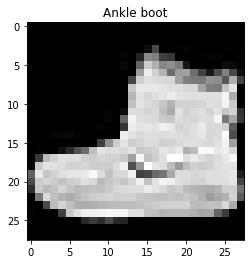

In [48]:
# Image as image
image, label = train_data[0]
# not working:
# plt.imshow(image)
# because it is NCWH


plt.imshow(image.squeeze(),cmap='gray')
plt.title(class_names[label])




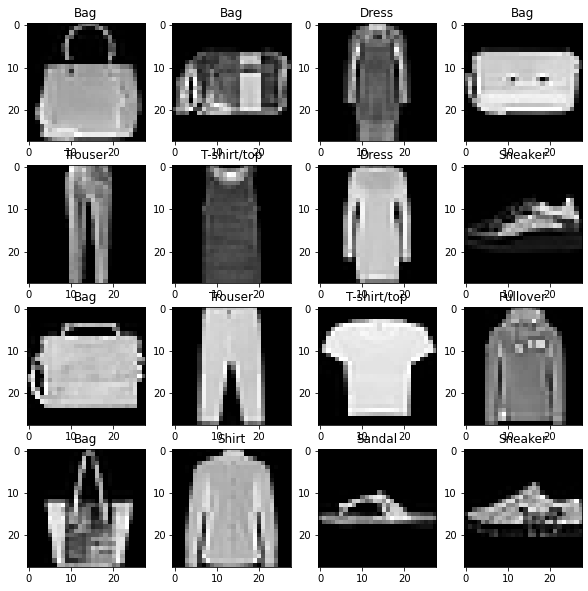

In [49]:
# more images (check out random samples!)
#torch.manual_seed(42)
fig = plt.figure(figsize=(10,10))
rows=4
cols=4
for i in range(1,rows*cols+1):
  random_idx = torch.randint(0,len(train_data),size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows,cols,i)
  plt.imshow(img.squeeze(),cmap='gray')
  plt.title(class_names[label])

## 2. Prepare Data loader
At present, the data is in the form a pytorch datasets+the dataloader turns our dataset into a python iterable. Specifically we want to turn data into minibatches. Because
1. it might be hard to hold 60000 images in memory! - so it is computationally more efficient to break it down to e.g. 32
2. It gives the NN more chances to updates its gradients per epoch (check out Andrew Ng on minibatch gradient descent : https://www.youtube.com/watch?v=l4lSUAcvHFs

*kursiver Text*

In [50]:
## 2. Prepare Data Loader
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                              batch_size = BATCH_SIZE,
                              shuffle = False)


In [51]:
print(f'Dataloaders:  {train_dataloader, test_dataloader}')
print(f'Lengt of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}' )
print(f'Lengt of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}' )


Dataloaders:  (<torch.utils.data.dataloader.DataLoader object at 0x7f684be71220>, <torch.utils.data.dataloader.DataLoader object at 0x7f684bddee20>)
Lengt of train dataloader: 1875 batches of 32
Lengt of test dataloader: 313 batches of 32


In [52]:
# whats inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape
# this is the input and output shapes

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image Size: torch.Size([1, 28, 28])
Image label: 9, label size: torch.Size([])


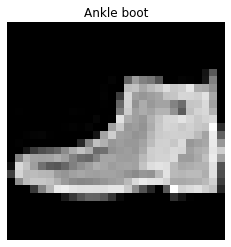

In [53]:
# visualize whats inside the dataloader (in one batch)
random_idx = torch.randint(0,len(train_features_batch),size = [1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(),cmap='gray')
plt.title(class_names[label])
plt.axis(False)
print(f'Image Size: {img.shape}')
print(f'Image label: {label}, label size: {label.shape}')

## 3. Model 0: Build a baseline model
Before starting to experiment wiht models, it is best practice to start with a baseline model. This is a simple model that will be incrementally improved with subsequent models - make more complicated if necessary!

In [54]:
# flatten layers
flatten_model = nn.Flatten()
x = train_features_batch[0]
output = flatten_model(x)

print(f'shape before flattening: {x.shape}')
print(f'shape after flattening: {output.shape}')


flatten_model = nn.Flatten()
x = train_features_batch
output = flatten_model(x)

print(f'shape before flattening: {x.shape}')
print(f'shape after flattening: {output.shape}')

shape before flattening: torch.Size([1, 28, 28])
shape after flattening: torch.Size([1, 784])
shape before flattening: torch.Size([32, 1, 28, 28])
shape after flattening: torch.Size([32, 784])


### 3.1 Base model: Linear MOdel 
(thats why we need flatten layer)

In [55]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units:int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape,
                       out_features = hidden_units),
        nn.Linear(in_features = hidden_units,
                       out_features = output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [56]:
torch.manual_seed(42)
model_0 = FashionMNISTModelV0(input_shape = 784, hidden_units = 10, output_shape = len(class_names))
model_0 = model_0.to('cpu')

In [57]:
# test the model with a dummy
dummy_x = torch.rand([1,1,28,28])
model_0(dummy_x)# checkout
#model_0.state_dict())

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [58]:
# setup loss and optim
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.01)

In [59]:
#!pip install  torchmetrics
import torchmetrics

In [60]:
import requests
from pathlib import Path

# downloadhelperfunction
if Path('helper_functions.py').is_file():
  print('helper function already downloaded')
else:
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py','wb') as f:
    f.write(request.content)

from helper_functions import accuracy_fn


helper function already downloaded


### A function to time the experiments
Should always track
* model performance
* how fast it runs

In [61]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end:float,
                     device: torch.device = None):
  """ Prints difference between start and end time """
  total_time = end - start
  print(f'Total time on {device}: {total_time:.3f} seconds')

start_time = timer()
# some code
end_time = timer()
print_train_time(start = start_time, end = end_time, device = 'cpu')

Total time on cpu: 0.000 seconds


### 3.3 Build a training loop and train model
now we will train on batches of data
1. loop through epochs
2. loop through training batches, perform training steps, compute train loss per batch
3. loop through testing batches, perform testing steps, compute the test loss per batch
4. print out whats happening
5. time it all

In [62]:
from tqdm.auto import tqdm

train_time_start_on_cpu = timer()
# start small
epochs = 3

for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}\n')
  #Training
  train_loss = 0 # initialize for each epoch
  # Add a loop for batches
  for batch, (X,y) in enumerate(train_dataloader):
    model_0.train()
    y_pred = model_0(X)
    loss = loss_fn(y_pred,y)
    train_loss+= loss # accumualte train loss across batch
    optimizer.zero_grad()
    loss.backward()   # y=but backpropagate on the current stewise loss
    optimizer.step() # now updated once per batch instead of per epoch

    if batch % 400 == 0:
      print(f'Have looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples')

  # now compute average trainloss by length of train dataloader -> average batch loss
  train_loss /= len(train_dataloader)

  ### Testing loop, This is done per batch now
  test_loss, test_acc = 0,0
  model_0.eval()
  with torch.inference_mode():
    for X_test,y_test in test_dataloader:
      test_pred = model_0(X_test)
      test_loss += loss_fn(test_pred,y_test)
      test_acc += accuracy_fn(y_true = y_test, y_pred = test_pred.argmax(dim=1))    # the one with the highest probabilitz

    test_loss/=len(test_dataloader)
    test_acc/= len(test_dataloader)
  # print out whats happening
    print(f'\n Epoch: {epoch} |Train loss: {train_loss:.4f} |Test loss: {train_loss:.4f}| Test accuracy: {test_acc:.4f} ')
  
  train_time_end_on_cpu = timer()
  total_train_time_model_0 = print_train_time(start = train_time_start_on_cpu,
                                              end = train_time_end_on_cpu,
                                              device = str(next(model_0.parameters()).device)) 



  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0

Have looked at 0/60000 samples
Have looked at 12800/60000 samples
Have looked at 25600/60000 samples
Have looked at 38400/60000 samples
Have looked at 51200/60000 samples

 Epoch: 0 |Train loss: 0.9078 |Test loss: 0.9078| Test accuracy: 78.2149 
Total time on cpu: 13.360 seconds
Epoch: 1

Have looked at 0/60000 samples
Have looked at 12800/60000 samples
Have looked at 25600/60000 samples
Have looked at 38400/60000 samples
Have looked at 51200/60000 samples

 Epoch: 1 |Train loss: 0.5570 |Test loss: 0.5570| Test accuracy: 80.6609 
Total time on cpu: 25.461 seconds
Epoch: 2

Have looked at 0/60000 samples
Have looked at 12800/60000 samples
Have looked at 25600/60000 samples
Have looked at 38400/60000 samples
Have looked at 51200/60000 samples

 Epoch: 2 |Train loss: 0.5019 |Test loss: 0.5019| Test accuracy: 81.5495 
Total time on cpu: 33.833 seconds


## 4. Make Predictions


In [63]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """ Returns a dictionary coontaining the results of model prediction on data_loader"""
  loss,acc= 0,0

  with torch.inference_mode():
    for X,y in tqdm(data_loader):
      #make predictions
      y_pred = model(X)

      # accumulate the loss and acc values per batch
      loss+= loss_fn(y_pred,y)
      acc+= accuracy_fn(y_true = y,
                       y_pred=y_pred.argmax(dim=1))
    
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

# caclualte model_0 results on the test dataset

model_0_results = eval_model(model = model_0, 
                             data_loader = test_dataloader,
                             loss_fn = loss_fn,
                             accuracy_fn = accuracy_fn )


print(model_0_results)

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.5236040949821472, 'model_acc': 81.54952076677316}


## 5. Set up device agnostic code



In [64]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
#!nvidia-smi

cuda


## 6. Set up Model 1: Use a ReLU

In [80]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units:int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = input_shape,
                       out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units,
                       out_features = output_shape),
        #nn.ReLU()
    )

  def forward(self, x):
    return self.layer_stack(x)

In [81]:
#train_features_batch, train_labels_batch = next(iter(train_dataloader))
#train_features_batch.shape, train_labels_batch.shape
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape[3]
input_size = train_features_batch.shape[2]*train_features_batch.shape[3]

In [82]:
model_1 = FashionMNISTModelV1(input_shape = input_size, hidden_units = 10, output_shape = len(class_names))
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr=0.01)

In [83]:
print(len(train_dataloader))                # number of batches
print(len(train_dataloader.dataset))        # number of samples
print(BATCH_SIZE)                           # number of sample per batch
print(len(X))                               # number of sample per batch

1875
60000
32
32


### 6.1 Create a train loop and a test loop

In [103]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  
  model.train()
  train_loss = 0
  train_acc=0
  for batch, (X,y) in enumerate(dataloader):
    
    y_pred = model(X)
    loss = loss_fn(y_pred,y)            # loss per batch (32 samples)
    train_loss+=loss
    train_acc += accuracy_fn(y_pred.argmax(dim=1),y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if batch%400 ==0:
      #print(f'Have looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples')
      print(f"Current sample: {batch*len(X)}/{len(train_dataloader.dataset)}")
  
  
  train_loss /= len(train_dataloader)    # average loss per batch
  train_acc /= len(train_dataloader)
  

  return model, train_loss, train_acc


def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device
              ):
  test_loss = 0
  test_acc = 0
  model.eval()
  with torch.inference_mode():
    for batch, (X_test,y_test) in enumerate(test_dataloader):
      y_pred_test = model(X_test)
      test_loss += loss_fn(y_pred_test,y_test)
      test_acc += accuracy_fn(y_pred_test.argmax(dim=1),y_test)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
  
  return model, test_loss, test_acc

  



In [102]:
train_time_start=timer()
epochs=3

for epoch in tqdm(np.arange(epochs)):
  
  # TRAINING LOOP
  model_1, train_loss = train_step(model = model_1, 
                                  dataloader = train_dataloader,
                                  loss_fn = loss_fn,
                                  optimizer=optimizer,
                                  accuracy_fn = accuracy_fn
                                  device = device)
  # TESTING LOOP
  model_1, test_loss, test_acc = test_step(model = model_1, 
                                  dataloader = test_dataloader,
                                  loss_fn = loss_fn,
                                  optimizer=optimizer,
                                  accuracy_fn = accuracy_fn,
                                  device = model.device())
  
  print(f"Epoch: {epoch} | Train loss {train_loss:.4f} | Test loss {test_loss:.4f} | Test accuracy {test_acc:.4f}")

  train_time_end = timer()
  total_train_time_model_1 = print_train_time(train_time_start,
                                            train_time_end,
                                            device = str(next(model_1.parameters()).device))

  






SyntaxError: ignored